# AI Agents for Privacy Analysis in mHealth App Traffic

The following content until Cell x has not been changed from the original. 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as mtick
import seaborn as sns

import src.load_data as loader
import src.clean_data as cleaner
import src.find_pii as finder
import src.thesis_ai as ai # This is the module for the AI Implementation

In [5]:
font_dirs = ["./fonts/linux_libertine"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Linux Libertine'

## Load Data from SQLite Databases and JSON files

For this analysis, we use data from four sources:
- The self-declared data handling practices of the apps scraped from the Google Play Store's Data Safety page of each app.
- The traffic data collected by Heimdall during the automated crawl where each app was opened for 60 seconds without any user interaction.
- The traffic data collected by Heimdall during the 2024 manual crawl where we manually interacted with the apps to simulate a user's interactions, such as logging in, entering personal data, and using the app's features as far as possible to collect as much traffic data as possible.
- The traffic data collected by Heimdall during the 2022 manual crawl that was performed in the same way as the 2024 manual crawl.

The data is loaded using the `DataLoader` class from the `load_data` module, which loads the data from the SQLite databases and JSON files and provides the data in a structured format. To ensure consistency, we only load the data of apps that are present in all three traffic datasets.

In [4]:
dl = loader.DataLoader('data/automated_crawl.db', 'data/manual-crawl.db', 'data/data-handling.json', './data/manual-log.csv', './data/tracker-domains.txt')

apps = dl.apps
data_handling = dl.data_handling
traffic_auto_original = dl.traffic_auto
traffic_manual_original = dl.traffic_manual
third_party = dl.third_party
permissions = dl.permissions

## Clean Data

The first step is to clean the traffic data. We will remove binary data to speed up the analysis by focusing on plaintext content, replace base64 encoded data where possible, and URL decode the data. This will make it easier to search for PII in the traffic data. Since we're focusing on the analysis of PII leaving the device, we will also remove the response content from the traffic data to reduce the amount of data we need to process.

We're using the `clean_data` module for this step.

In [7]:
traffic_auto_clean = cleaner.clean_traffic(traffic_auto_original)
traffic_manual_clean = cleaner.clean_traffic(traffic_manual_original)

## Define Regular Expressions for PII Detection

We define regular expressions to detect PII in the traffic data. The regular expressions are grouped into categories based on the type of PII they detect. We use the following categories:
- Device Identifiers
- Location
- User Identifiers
- Fitness info
- Female health info
- Health info (medical)

### Device Identifiers
- Device model
- Screen resolution
- Carrier name
- OS build
- API level

In [6]:
r_did = [{'regex': re.compile(r'(?i)pixel.?6a|bluejay'), # Pixel 6A, Samsung Galaxy A13
          'name': 'Device model',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)\b1080\b'),
          'name': 'Resolution',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # screen width (height varies)
         {'regex': re.compile(r'(?i)nettokom'),
          'name': 'Carrier name',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # carrier name
         {'regex': re.compile(r'(?i)tp1a.220624.021.A1'),
          'name': 'OS build',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'}, # OS build
         {'regex': re.compile(r'(?i)api.{1,15}33'),
          'name': 'API level',
          'category': 'Device IDs',
          'ds_category': 'Device or other IDs',
          'specificity': 'Standard'} # API level
         ]

### Location
- Locale
- Timezone
- Country
- Country code
- City
- Latitude
- Longitude

In [7]:
r_loc = [{'regex': re.compile(r'(?i)(?<!/)berlin'),
          'name': 'City',
          'category': 'Location',
          'ds_category': 'Approximate location',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)(52[\.,]5)\d*|(52[\.,]6)\d*'),
          'name': 'Latitude',
          'category': 'Location',
          'ds_category': 'Precise location',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)(13[\.,]3)\d*|(13[\.,]4)\d*'),
          'name': 'Longitude',
          'category': 'Location',
          'ds_category': 'Precise location',
          'specificity': 'Standard'}
         ]

### User Identifiers
- Name
- Email address
- Advertising ID
- Age
- Date of birth
- Gender

In [8]:
r_uid = [{'regex': re.compile(r'(?i)freya'), # first name is enough, we never entered the last name without it
          'name': 'Name',
          'category': 'User Info',
          'ds_category': 'Name',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)mhealthcrawl2024@gmail.com'),
          'name': 'Email address',
          'category': 'User Info',
          'ds_category': 'Email address',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)30f17059'),
          'name': 'Advertising ID',
          'category': 'User Info',
          'ds_category': 'User IDs',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)\bage.{0,20}?\b34\b'),
          'name': 'Age',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'}, # age
         {'regex': re.compile(r'(?i)\b1990\b|631234800239'),
          'name': 'Date of birth',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'},
         {'regex': re.compile(r'(?i)female|gender'),
          'name': 'Gender',
          'category': 'User Info',
          'ds_category': 'Other info',
          'specificity': 'Standard'},
         ]

### Fitness info
- Body height
- Body weight
- Body weight goal
- BMI
- Step count
- Eating habits
- Fitness goals
- Fitness level
- Mental wellbeing
- Sleep habits

In [9]:
r_ufd = [{'regex': re.compile(r'(?i)height.{1,20}170|"value":"?170'),
          'name': 'Body height',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)w.{20}65|weight.{20}143|current.?weight|start.?weight|"value":"?65|\[65.0\]|"note":"65"'),
          'name': 'Body weight',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)weight.{1,20}60|w.{120}80|target.?weight|goal.?weight|weight.?goal'),
          'name': 'Body weight goal',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)[^u]bmi.{1,20}22'),
          'name': 'BMI',
          'category': 'Body measurements',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)steps_goal|steps_progress|start_steps|"steps":5|step{1,20}271|goalStep'),
          'name': 'Step count',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)vegetarian|diet|drinkList'),
          'name': 'Eating habits',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)[^\.]lose.?weight[^\.]|[^\.]weight.{0,15}los[^\.]|diet.goal|main.goal|steps.goal|weight.change'),
          'name': 'Fitness goals',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)fitness.level|difficulty.{0,15}medium|level.{0,15}medium|beginner'),
          'name': 'Fitness level',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)stress|lack.?of.?sleep|forgetful'),
          'name': 'Mental wellbeing',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'},
         {'regex': re.compile(r'(?i)sleep.?analysis|sleep.?quality|sleep.?hours|sleep.?time|"sleep":"between_5_and_6|lack.?of.?sleep|wake.?up.?time'),
          'name': 'Sleep habits',
          'category': 'Fitness info',
          'ds_category': 'Fitness info',
          'specificity': 'Nonstandard'}
         ]

### Female health info
- Menstrual cycle length
- Period start date
- Period length
- Period symptoms
- Birth control

In [10]:
r_fhd = [{'regex': re.compile(r'(?i)cycle.{1,20}29'),
          'name': 'Cycle length',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)start.period|period.start|is_menstruation_began|cycle_day'),
          'name': 'Period start date',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)period.{1,20}5|duration_of_menstruation'),
          'name': 'Period length',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)acne|dysmenorrhea|discharge|cravings|mucus'),
          'name': 'Period symptoms',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)birth.control|contracept|pill.?record|pill.?count|pill.?date|vaginal_ring'),
          'name': 'Birth control',
          'category': 'Female health info',
          'ds_category': 'Health info',
          'specificity': 'Medical'}
         ]

### Health info (medical)
- Sexual activity
- Body temperature
- Heart rate
- Blood pressure (systolic and diastolic)
- Glucose levels
- Medical conditions (diabetes, headache, allergies)

### Apply Regexes

Now, we apply the regexes to the traffic data to detect PII. The `apply_regexes` function applies the regexes to the `request_content` and `response_content` of the traffic data and writes the detected PII categories to a new column named `detected_pii`.

In [11]:
r_uhd = [
         {'regex': re.compile(r'(?i)is_made_love|sex.life|used_condom'),
          'name': 'Sexual activity',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)temp.{1,20}37|\[37.0\]|"note":"37"'),
          'name': 'Body temperature',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)rate.{1,20}70|puls.{1,20}70'),
          'name': 'Heart rate',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)diastolic|systolic|dia.{1,20}75|sys.{1,20}100'),
          'name': 'Blood pressure',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)glucose|[^\.]blood.?sugar[^\.]'),
          'name': 'Glucose levels',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         {'regex': re.compile(r'(?i)medical.cond|headache|[^\.]diabetes[^\.]|allerg'),
          'name': 'Medical conditions',
          'category': 'Medical info',
          'ds_category': 'Health info',
          'specificity': 'Medical'},
         ]

In [12]:
r_combined_all = r_did + r_loc + r_uid + r_ufd + r_fhd + r_uhd
r_combined_health = r_ufd + r_fhd + r_uhd

From this point onward, the notebook includes extensions,
implementations, and analyses, which go beyond the scope of the
original code supplied in the referenced publication by Cory et al.

In [ ]:
traffic_manual_regexed_all = finder.apply_regexes(traffic_manual_clean, r_combined_all)
#Here, the regexes get applied to the manual crawl, exactly like Corys Pipeline. 
#The result is a dataframe which has all regex-detection values and the original Http Traffic body



In [ ]:
# To be able to test the API with a limited amount of data we can use .head() to use a subset of the http requests. 
# This was useful for testing the API and Integration of results. For the final evaluation we delete .head() and make a simple copy
traffic = traffic_manual_regexed_all.copy() 

We will use the OpenAI Batch-API to Implement our 2 Step-detection Workflow. For that we need to create a JSONL-File with each line being one detection request.
First, we need to implement the settings for our Model:

In [12]:
MODEL = "gpt-4.1-mini-2025-04-14" #OpenAI model snapshot for reproducability
TEMPERATURE = 0.1 # Temperature of Model
MAX_TOKENS = 4000 # Max Output Tokens 

Now we create the JSONL File. 
we created 2 new folders for the thesis evaluation: data_thesis ad figuers_thesis 

In [13]:
#Initialize the AI Agent
agent = ai.AI_Agent(MODEL,TEMPERATURE,MAX_TOKENS)

Creating the Batch file for AI Detection

In [14]:
detection_batch_path = agent.create_detection_batch_file(
    traffic, 
    r_combined_all,
    batch_file_path="data_thesis/batches/detection/detection_batch_full_crawl_3_7.jsonl"
)

NameError: name 'traffic' is not defined

In [ ]:
#Here, the batch file is Uploaded to the OPENAI-API
batch_job_id = agent.upload_batch_file("data_thesis/batches/detection/detection_batch_full_crawl_3_5.jsonl")

In [ ]:
#This is for checking the status.
status = agent.check_batch_status("batch_6919f65091308190afca2084932cec45")
print(status)
# For Debugging: the following lines give the error code if the Batch job failed. 
batch_job = agent.client.batches.retrieve("batch_6919f65091308190afca2084932cec45")
print(f"Status: {batch_job.status}")
print(f"Errors: {getattr(batch_job, 'errors', None)}")
print(f"Request ID: {getattr(batch_job, '_request_id', None)}")

In [ ]:
results_path = agent.download_results(
    "batch_6919d5fce7148190be1762f7bb1bc2ec",
    "data_thesis/results/detection/detection_results_full_crawl_3_5.jsonl"
)

In [ ]:
traffic_with_detection = agent.integrate_detection_results(
    "data_thesis/results/detection/detection_results_full_crawl.jsonl",
    traffic,
    r_combined_all
)

Each Positive Detection will be validated individually. For that, a second Batch job is needed. 

In [ ]:
validation_batch_path = agent.create_validation_batch_file(
    traffic_with_detection,  
    r_combined_all,
    "data_thesis/batches/validation/validation_batch_full.jsonl"
)


In [ ]:
validation_job_id = agent.upload_batch_file("data_thesis/batches/validation/v13.jsonl")

In [ ]:
status = agent.check_batch_status("batch_6919ff5d44cc8190ac21de3185b96aa1")
print(status)

In [ ]:
validation_results_path = agent.download_results(
    "batch_6919ff5d44cc8190ac21de3185b96aa1",
    "data_thesis/results/validation/v13.jsonl"
)

In [ ]:
traffic_final = agent.integrate_validation_results(
    "data_thesis/results/validation/validation_final_all.jsonl",
    traffic_with_detection
)

In [ ]:
traffic_final.head(5)  #quick check to see if all columns look as planned

After successfull integration of the validation results, the final dataframe is saved to be used for the Evaluation of the Results.

In [ ]:
traffic_final.to_csv('data_thesis/results/traffic_final.csv', index=False) #To have quick access to columns
traffic_final.to_pickle('data_thesis/results/traffic_final.pkl')  

print("DataFrame saved:")
print(f"- CSV: data_thesis/results/traffic_final.csv")
print(f"- Pickle: data_thesis/results/traffic_final.pkl")

## 6.2 Quantitative Comparison of Detection Volumes


Question: Which categories habe the biggest differences in Detection. Are there categories where AI detected more or are there Categories where AI detected less.


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\diverging_bars_vertical.pdf


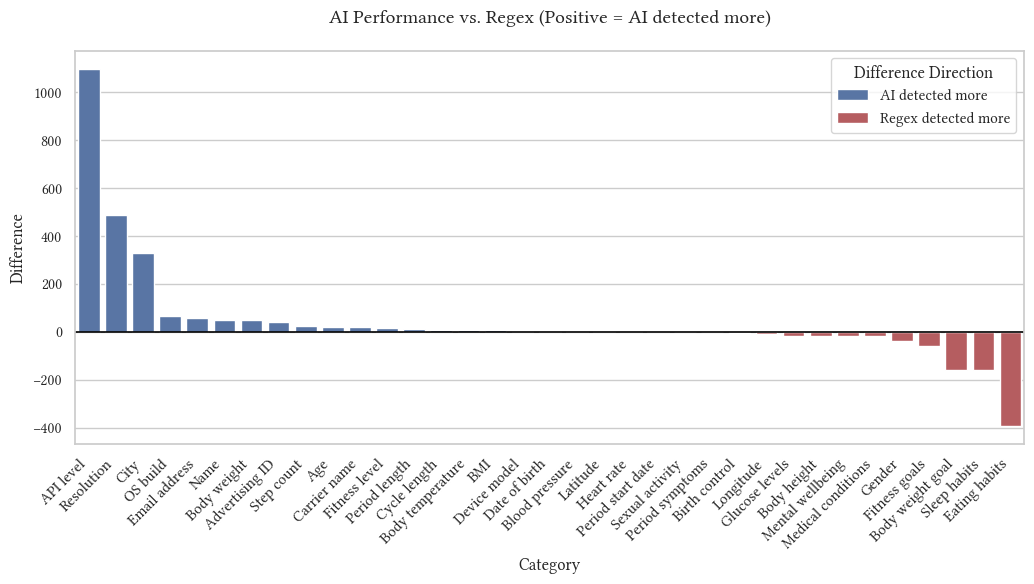

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import src.thesis_plot_data as thesis_plot
importlib.reload(thesis_plot)

traffic_final = pd.read_pickle('data_thesis/results/traffic_final.pkl')
summary = []



for pattern in r_combined_all:
    pattern_name = pattern['name']
    regex_col = f"detected_{pattern_name}"
    ai_col = f"ai_detected_{pattern_name}"
    
    if regex_col in traffic_final.columns and ai_col in traffic_final.columns:
        regex_count = traffic_final[regex_col].sum()
        ai_count = traffic_final[ai_col].sum()
        
        summary.append({
            'Pattern': pattern_name,
            'Regex Detections': regex_count,
            'AI Detections': ai_count,
            'Differenz': ai_count - regex_count
        })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values('Differenz', ascending=False)
thesis_plot.plot_horizobtal_diverging_bars(
    summary_df,
    category_col='Pattern',
    value_col='Differenz',
    title='AI Performance vs. Regex (Positive = AI detected more)',
    x_label='Category',
    y_label='Difference',
    pdf_filename='diverging_bars_vertical'
)
plt.show()

Table: Numeric comparison (Evaluation 6.2)

Tabelle gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\summary_table_full.pdf


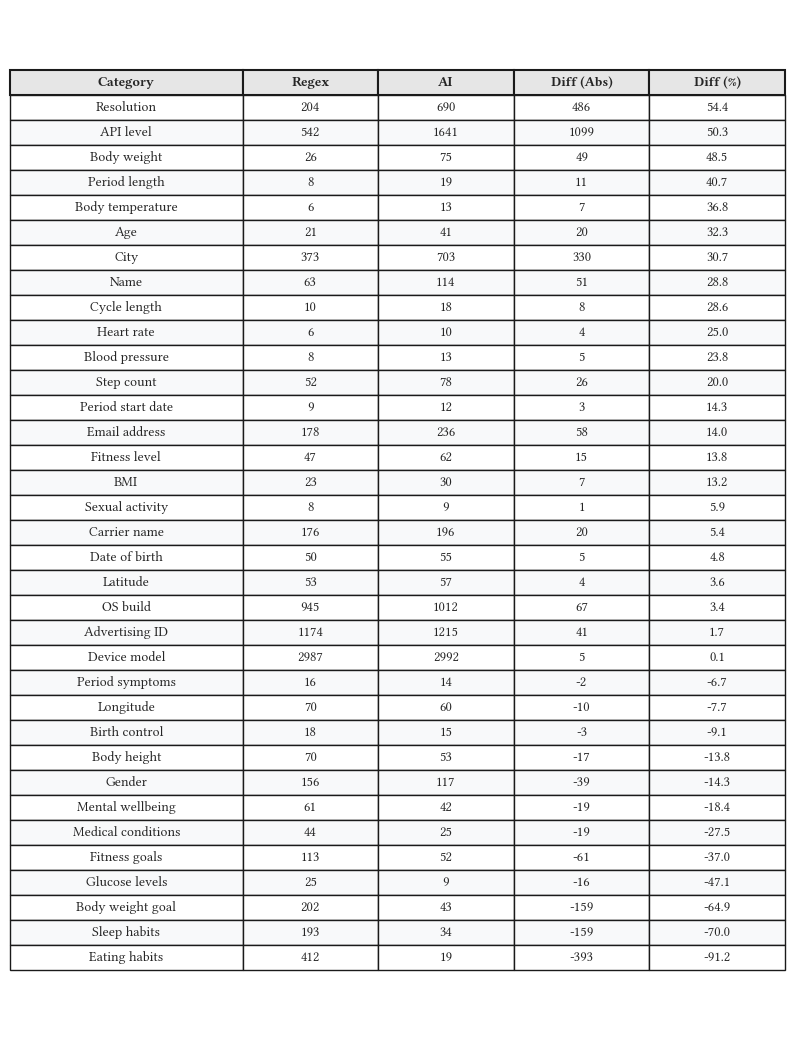

In [12]:
thesis_plot.plot_summary_table(summary_df, filename='summary_table_full')
plt.show()

##6.3 Categories where AI Detects More than Regex
###6.3.1 API Level

Generiere Overlap-Plot für API level...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\ai_more_api_level.pdf


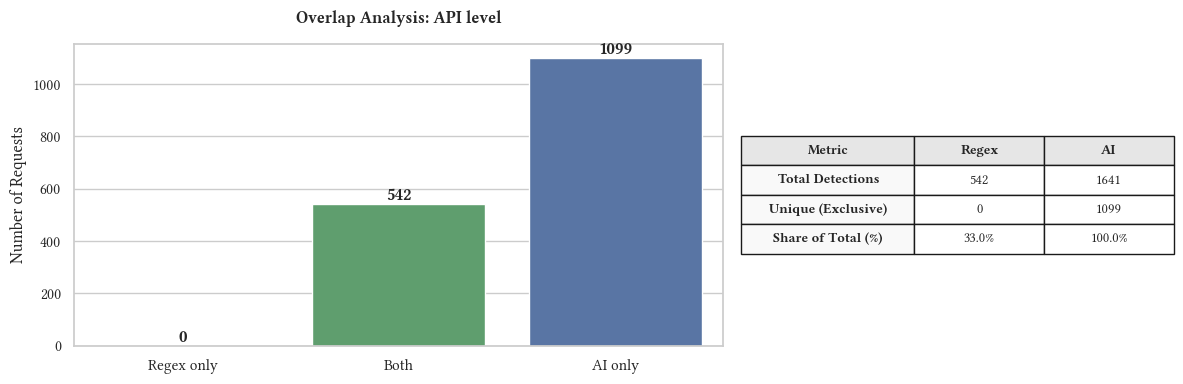


=== Deep Dive Analyse: API level ===
Modus: AI-Only Detections (AI=True, Regex=False)
Anzahl Treffer gesamt: 1099
Zeige Stichprobe von n=20 (Seed=42):


Index                                                    App  \
0   15130                                    cc.pacer.androidapp   
1   24314                  loseweight.weightloss.workout.fitness   
2   14281                                           com.wsl.noom   
3   16038                        com.fitnesskeeper.runkeeper.pro   
4   14025                                           com.wsl.noom   
5   16797                        com.fitnesskeeper.runkeeper.pro   
6    1964                                       com.calm.android   
7   13275                                           com.wsl.noom   
8   18280                                       com.clue.android   
9   25902                           com.blood.pressure.bptracker   
10  26178                                    com.repsi.heartrate   
11  25587                          sixpack.sixpackabs.absworkout   
12  12767                               com.myfitnesspal.android   
13  25247               periodtracker.pregnancy.ovulationtracker   
14   6474                            com.healthtap.userhtexpress   
15  14638                                           com.wsl.noom   
16   1704                                           com.bodyfast   
17   9935                  loseweight.weightloss.workout.fitness   
18  17532  steptracker.healthandfitness.walkingtracker.pedometer   
19  21767                bodyfast.zero.fastingtracker.weightloss   

                                           Host  \
0                           clients4.google.com   
1                firebaselogging.googleapis.com   
2                   buyflow-web-assets.noom.com   
3                           clients4.google.com   
4                                34.120.195.249   
5                              api.iterable.com   
6                                  3.230.51.112   
7                                  www.noom.com   
8                            collector.clue.run   
9           firebaseremoteconfig.googleapis.com   
10  firebaseremoteconfigrealtime.googleapis.com   
11          firebaseremoteconfig.googleapis.com   
12                      aax.amazon-adsystem.com   
13          firebaseremoteconfig.googleapis.com   
14                         sdk.iad-02.braze.com   
15                             appdata.noom.com   
16                                172.67.21.215   
17          firebaseremoteconfig.googleapis.com   
18                          clients4.google.com   
19                                  ad.leap.app   

                                                            AI Reasoning  \
0                      API level '33' is explicitly present in the data.   
1                            Platform version '33' matches API level 33.   
2       Android 13 corresponds to API level 33, indicated in user agent.   
3                         API level '33' explicitly present in the data.   
4    User agent mentions 'Android 13' which corresponds to API level 33.   
5                                   SDK version 33 matches API level 33.   
6                                   SDK version 33 matches API level 33.   
7   Android 13 corresponds to API level 33, indicated in OS Major field.   
8                   OS version '13' corresponds to Android API level 33.   
9                            Platform version '33' matches API level 33.   
10                            PlatformVersion '33' matches API level 33.   
11                            PlatformVersion '33' matches API level 33.   
12                          OS version '13' corresponds to API level 33.   
13                       PlatformVersion is '33', matching API level 33.   
14                         OS version '33' matches API level 33 pattern.   
15          API level '33' implied by Android 13 (API 33) in user agent.   
16                    API level '33' present in device.os_version field.   
17                         PlatformVersion is 33, matching API level 33.   
18                          API level '33' found in SYSTEM 

In [13]:
#API Level Evaluation:

category = 'API level'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='ai_more_api_level')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category='API level', 
    mode='ai_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

##6.3.2 Resolution

Generiere Overlap-Plot für Resolution...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\ai_more_resolution.pdf


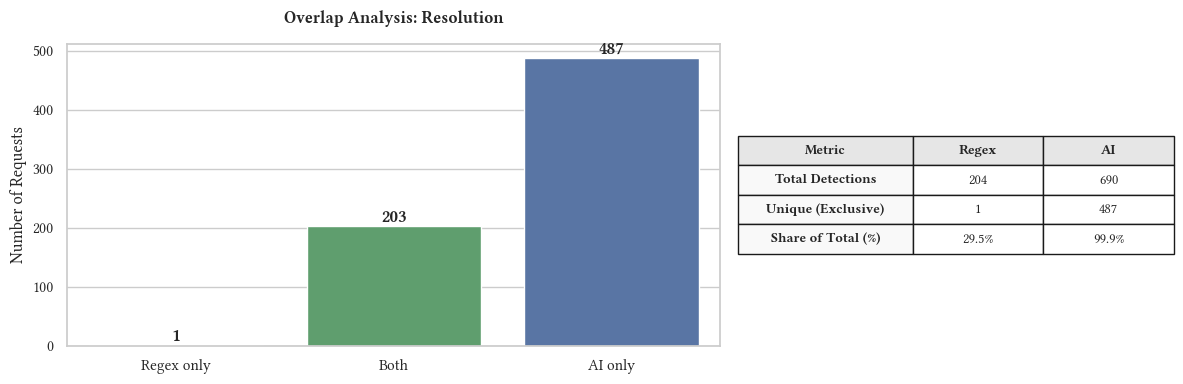


=== Deep Dive Analyse: Resolution ===
Modus: Regex-Only Detections (Regex=True, AI=False)
Anzahl Treffer gesamt: 1
Zeige Stichprobe von n=1 (Seed=42):


,Index,App,Host,AI Reasoning,Validation Reasoning,Body Content
0,22919,com.northcube.sleepcycle,app.adjust.com,Display width '1080' matches resolution pattern.,"Display width '1080' is a numeric screen resolution, not PII.",gps_adid_attempt=1&country=GB&api_level=33&event_buffering_enabled=0&hardware_name=TP1A.220624.021.A1&app_version=4.24.06.8294-production&app_token=z8hobwiqtxc0&event_count=1&session_length=4&created_at=2024-03-02T21:02:47.799Z+0100&device_type=phone&language=en&gps_adid=30f17059-4642-4c81-a345-2621a89af205&connectivity_type=1&mcc=262&device_manufacturer=Google&display_width=1080&event_token=ooy0l7&time_spent=4&device_name=Pixel+6a&needs_response_details=1&os_build=TP1A.220624.021.A1&cpu_type=arm64-v8a&screen_size=normal&screen_format=long&gps_adid_src=service&subsession_count=1&mnc=03&os_version=13&android_uuid=415d67a5-dab5-4b92-a8f8-20f50c07b6ce&environment=production&screen_density=high&attribution_deeplink=1&session_count=1&display_height=2156&package_name=com.northcube.sleepcycle&os_name=android&ui_mode=1&tracking_enabled=1&sent_at=2024-03-02T21:02:47.840Z+0100


In [14]:
# --- Resolution Evaluation ---
category = 'Resolution'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"
val_reasoning_col = f"ai_validation_reasoning_{category}"
content_col = 'request_content'

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='ai_more_resolution')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category='Resolution', 
    mode='regex_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

6.3.3 Advertising ID

Generiere Overlap-Plot für Advertising ID...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\ai_more_advertising.pdf


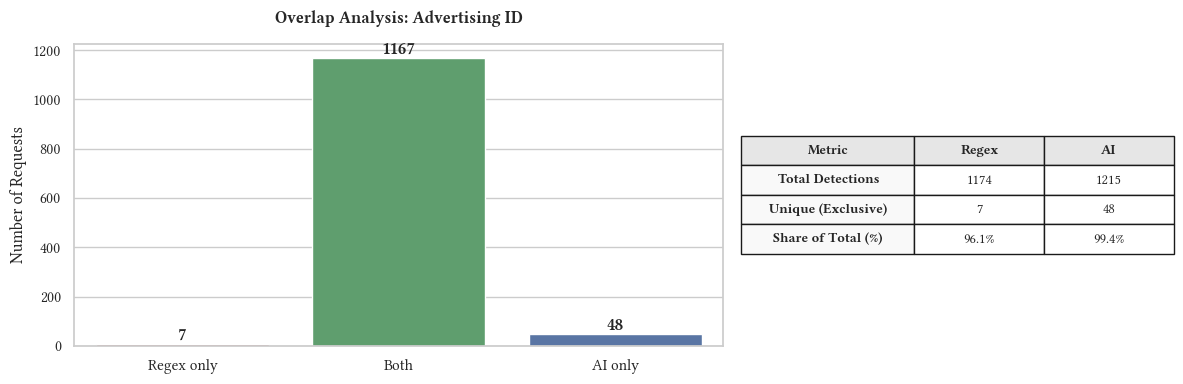


=== Deep Dive Analyse: Advertising ID ===
Modus: Regex-Only Detections (Regex=True, AI=False)
Anzahl Treffer gesamt: 7
Zeige Stichprobe von n=7 (Seed=42):


,Index,App,Host,AI Reasoning,Validation Reasoning,Body Content
0,3314,andrei.brusentcov.eye_exercises.free,fundingchoicesmessages.google.com,Ad ID '30f17059-5128-4c81-a345-2621a89af205' matches advertising ID pattern.,"Detected adid is a UUID, not a short advertising ID '30f17059' as per pattern.","{""admob_app_id"":""ca-app-pub-7668162072030107~9730426477"",""is_lat"":false,""adid"":""30f17059-5128-4c81-a345-2621a89af205"",""device_info"":{""os_type"":""ANDROID"",""model"":""Pixel 6a"",""android_api_level"":33},""language_code"":""en-GB"",""tag_for_under_age_of_consent"":false,""screen_info"":{""width"":411,""height"":821,""density"":2.625,""screen_insets"":[{""top"":0,""left"":480,""right"":625,""bottom"":118}]},""app_info"":{""package_name"":""andrei.brusentcov.eye_exercises.free"",""publisher_display_name"":""Eye exercises"",""version"":""7""},""sdk_info"":{""version"":""2.0.0""}}"
1,7871,si.modula.android.instantheartrate,eu1.clevertap-prod.com,Advertising ID '30f17059' partially present in 'g' field.,"Detected string '30f17059' is part of a longer alphanumeric ID, not a standalone Advertising ID.","[{""g"":""__g30f1705946424c81a3452621a89af205"",""type"":""meta"",""af"":{""Build"":""9839"",""Version"":""6.3.2"",""OS Version"":""13"",""SDK Version"":40200,""Make"":""Google"",""Model"":""Pixel 6a"",""Carrier"":"""",""useIP"":true,""OS"":""Android"",""wdt"":2.52,""hgt"":5.02,""dpi"":420,""dt"":1,""wifi"":true,""BluetoothVersion"":""ble"",""Radio"":""Unknown""},""id"":""WRZ-77R-R65Z"",""tk"":""2aa-120"",""l_ts"":1709503516,""f_ts"":1709503095,""ct_pi"":""Email,Identity"",""ddnd"":true,""rtl"":[],""rct"":0,""ait"":0,""frs"":true,""arp"":{""sv"":40200,""dh"":-1492827486,""wdt"":2,""d_ts"":1709503096,""hgt"":5,""av"":""6.3.2"",""v"":2,""e_ts"":0,""j_n"":""ZWhjeQYCBwc="",""i_n"":""ZWhjeQYCBwc="",""r_ts"":1709503515,""id"":""WRZ-77R-R65Z"",""k_n"":""DHg6LltdVVU7NiIiLz8+ewBwVlk2Mz5lNDU\/aR4SAAFuYmd9Z2xkcxBt"",""j_s"":""{}""},""imp"":0,""tlc"":[]}, {""profile"":{""Azumio Application"":""Instant Heart Rate"",""tz"":""Europe\/Berlin""},""s"":1709503522,""pg"":1,""type"":""profile"",""ep"":1709503522,""f"":false,""lsl"":0,""dsync"":true}]"
2,18252,com.clue.android,api.helloclue.com,Advertising ID '30f17059' present in 'gps_adid' field.,"Detected '30f17059-5128-4c81-a345-2621a89af205' is a full Advertising ID, not just '30f17059'.","{""id_token"":""eyJhbGciOiJSUzI1NiIsImtpZCI6ImFkZjVlNzEwZWRmZWJlY2JlZmE5YTYxNDk1NjU0ZDAzYzBiOGVkZjgiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiI0NzAxMTg0MDI4MDMtZWo0Nmk4dGZmbTNtdDlkbnA2Yzh1cGdyODlmM2s3MmMuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiI0NzAxMTg0MDI4MDMtZWo0Nmk4dGZmbTNtdDlkbnA2Yzh1cGdyODlmM2s3MmMuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDI5NTUzMDMwMTM4ODQ1MDAwNTMiLCJlbWFpbCI6ImhlaW1kYWxscGl4ZWwwMkBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXRfaGFzaCI6Imd1d09ULW9lWmgwa0hHLWFfd1E4cmciLCJub25jZSI6InotbktkTDI0OUxiZTVmVDFSU1JDSHciLCJuYW1lIjoiRnJleWEgSGVpbWRhbGwiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jSUhGQWNWZDdLbDRiSlZWbVpkSV9JeHVxdXdHaHlOMDNFWDhkbW5pNUY2PXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkZyZXlhIiwiZmFtaWx5X25hbWUiOiJIZWltZGFsbCIsImlhdCI6MTcxMTM4ODc2NSwiZXhwIjoxNzExMzkyMzY1fQ.ohrF4ajvsttkpBXBF0I6A_VVBPATcTsYYfu7FtfY54LSf7cI8hfGOiSykp4IYDBHevvrSvvCWoYOP1Z2jI8b2zswicEA4bwvcD9Yn8qQv4A4v0wtozbBK2qULTFtidiIWxlvNc4we43aygKa1d1nOXl1SmU8m1TKf1LiJ4Dbh3n_XungrA6_z9IBr8itztXQhstDHT-vVe57G_PH-AF8_qQixTWqZqrhALnzlhOdVdsB8nCPlocufLW3KLP0BxCGTu2R3L4eyanr14jILwH7UbYguZfSusrQfzlo6pbqfbfmSxw_rRFhr4U8zBDqG9lhP_-DgDUyx6rzRgqFowR2tA"",""gps_adid"":""30f17059-5128-4c81-a345-2621a89af205"",""uses_lite_mode"":false,""consented_to_version"":""231206"",""consented_to_version_tos"":""231206"",""consented_to_version_health_data"":""230913""}"
3,11961,musclebooster.workout.home.gym.abs.loseweight,pinpoint.us-east-1.amazonaws.com,Advertising ID '30f17059' found in 'idfa' attribute.,"Detected 'idfa' value is a UUID, not a valid Advertising ID format.","{""

In [18]:
# --- Advertising ID Evaluation ---
category = 'Advertising ID'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"
val_reasoning_col = f"ai_validation_reasoning_{category}"
content_col = 'request_content'

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='ai_more_advertising')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category, 
    mode='regex_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

6.4.1 Sleep habits

Generiere Overlap-Plot für Sleep habits...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\regex_more_sleep_habits.pdf


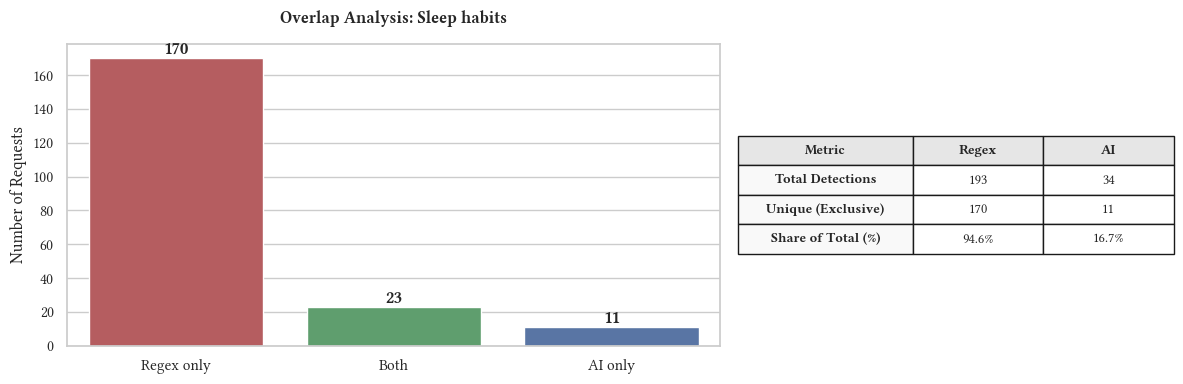


=== Deep Dive Analyse: Sleep habits ===
Modus: Regex-Only Detections (Regex=True, AI=False)
Anzahl Treffer gesamt: 170
Zeige Stichprobe von n=20 (Seed=42):


Index                                            App  \
0   24014                             ipnossoft.rma.free   
1    3453                             co.thefabulous.app   
2   23994                             ipnossoft.rma.free   
3    3413                             co.thefabulous.app   
4   24019                             ipnossoft.rma.free   
5   24038                             ipnossoft.rma.free   
6   24042                             ipnossoft.rma.free   
7   20799  bloodsugar.bloodsugarapp.diabetes.diabetesapp   
8   23979                             ipnossoft.rma.free   
9   23909                             ipnossoft.rma.free   
10   1321                             ipnossoft.rma.free   
11  24033                             ipnossoft.rma.free   
12  24010                             ipnossoft.rma.free   
13  16875                       com.northcube.sleepcycle   
14  23938                             ipnossoft.rma.free   
15  23959                             ipnossoft.rma.free   
16   1342                             ipnossoft.rma.free   
17  23983                             ipnossoft.rma.free   
18  23949                             ipnossoft.rma.free   
19  23982                             ipnossoft.rma.free   

                                            Host  \
0                               api.iterable.com   
1   us-central1-thefabulousco.cloudfunctions.net   
2                               api.iterable.com   
3   us-central1-thefabulousco.cloudfunctions.net   
4                               api.iterable.com   
5                               api.iterable.com   
6                               api.iterable.com   
7                 firebasestorage.googleapis.com   
8                               api.iterable.com   
9                               api.iterable.com   
10                                  34.200.49.11   
11                              api.iterable.com   
12                              api.iterable.com   
13                             api.amplitude.com   
14                              api.iterable.com   
15                              api.iterable.com   
16                                  34.200.49.11   
17                              api.iterable.com   
18                              api.iterable.com   
19                              api.iterable.com   

                                                    AI Reasoning  \
0                   No sleep habits or sleep quality info found.   
1     No sleep habits like '5-6 hours' or 'sleep quality' found.   
2                       No sleep duration or quality info found.   
3         No sleep habits like 5-6 hours or sleep quality found.   
4   No sleep habits or sleep quality info found in request body.   
5          Sleep habits like 5-6 hours or sleep quality missing.   
6                       No sleep duration or quality info found.   
7                    No sleep duration or quality info detected.   
8                     No sleep duration or quality info present.   
9                     No sleep duration or quality info present.   
10            No sleep habits like sleep hours or quality found.   
11       No sleep habits like sleep duration or quality present.   
12                      No sleep duration or quality info found.   
13           No sleep habit details like hours or quality found.   
14                   No sleep duration or quality info detected.   
15                    No sleep duration or quality info present.   
16                   No sleep duration or quality info detected.   
17                    No sleep duration or quality info present.   
18            No sleep habits like sleep quality or hours found.   
19            No sleep habits like sleep hours or quality found.   

   Validation Reasoning  \
0                  None   
1                  None   
2                  None   
3                  None   
4                  None   
5                  None   
6                  None   
7    

In [14]:
# --- Sleep Habits Evaluation ---
category = 'Sleep habits'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"
val_reasoning_col = f"ai_validation_reasoning_{category}"
content_col = 'request_content'

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='regex_more_sleep_habits')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category, 
    mode='regex_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

Generiere Overlap-Plot für Body weight goal...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\regex_more_weight_goal.pdf


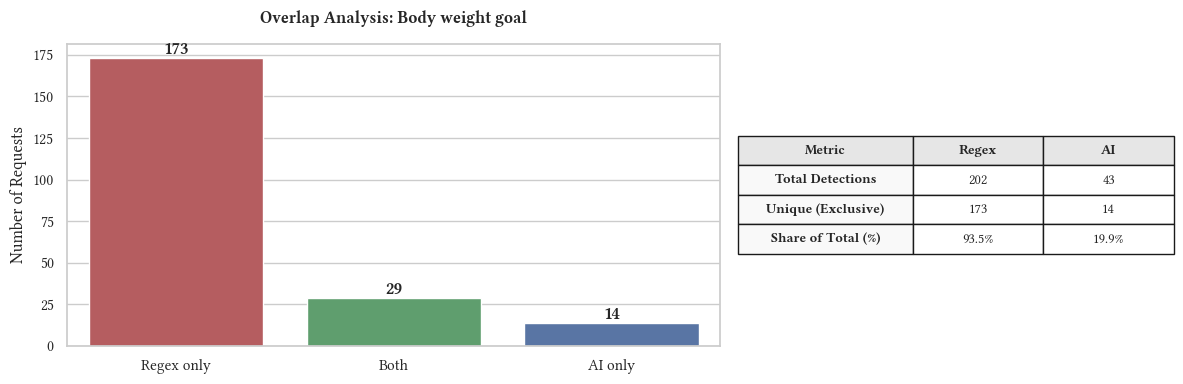


=== Deep Dive Analyse: Body weight goal ===
Modus: Regex-Only Detections (Regex=True, AI=False)
Anzahl Treffer gesamt: 173
Zeige Stichprobe von n=20 (Seed=42):


Index                      App                Host  \
0   21931      cc.relive.reliveapp   asp.api.relive.cc   
1   15634      cc.relive.reliveapp   asp.api.relive.cc   
2   18274         com.clue.android  collector.clue.run   
3   15763      cc.relive.reliveapp   asp.api.relive.cc   
4   18312         com.clue.android  collector.clue.run   
5   18335         com.clue.android  collector.clue.run   
6   15632      cc.relive.reliveapp   asp.api.relive.cc   
7   15523      cc.relive.reliveapp   asp.api.relive.cc   
8   18311         com.clue.android  collector.clue.run   
9   18306         com.clue.android  collector.clue.run   
10  18322         com.clue.android  collector.clue.run   
11  18266         com.clue.android  collector.clue.run   
12  18262         com.clue.android  collector.clue.run   
13  15622      cc.relive.reliveapp   asp.api.relive.cc   
14  15585      cc.relive.reliveapp   asp.api.relive.cc   
15   8182  com.sillens.shapeupclub     api.lifesum.com   
16  18309         com.clue.android  collector.clue.run   
17  15740      cc.relive.reliveapp   asp.api.relive.cc   
18  15542      cc.relive.reliveapp   asp.api.relive.cc   
19  18355         com.clue.android  collector.clue.run   

                                        AI Reasoning  \
0      No body weight goal '60 kg' or similar found.   
1              No body weight goal like 60 kg found.   
2                    No body weight goal info found.   
3   No body weight goal '60 kg' or equivalent found.   
4                 No body weight goal '60 kg' found.   
5                         No weight goal data found.   
6         No body weight goal or '60 kg' data found.   
7                         No weight goal data found.   
8       No body weight goal data like '60 kg' found.   
9         No body weight goal such as '60 kg' found.   
10             No body weight goal or '60 kg' found.   
11                No body weight goal '60 kg' found.   
12                        No weight goal data found.   
13     No body weight goal '60 kg' or similar found.   
14    Body weight goal '60 kg' or similar not found.   
15     Target weight 66.0 kg present, close to goal.   
16                     No weight goal data detected.   
17  No body weight goal '60 kg' or equivalent found.   
18                No body weight goal '60 kg' found.   
19                 No body weight goal data present.   

                                                                                           Validation Reasoning  \
0                                                                                                          None   
1                                                                                                          None   
2                                                                                                          None   
3                                                                                                          None   
4                                                                                                          None   
5                                                                                                          None   
6                                                                                                          None   
7                                                                                                          None   
8                                                                                                          None   
9                                                                                                          None   
10                                                                                                         None   
11                                                                                                         None   
12                                                                                                         None  

In [16]:
# --- Body Weight goal Evaluation ---
category = 'Body weight goal'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"
val_reasoning_col = f"ai_validation_reasoning_{category}"
content_col = 'request_content'

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='regex_more_weight_goal')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category, 
    mode='regex_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

Generiere Overlap-Plot für Eating habits...


c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\src\thesis_plot_data.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subset', y='Count', data=plot_data, ax=ax1, palette=colors)


Plot gespeichert: c:\Users\johan\Documents\TU_Berlin\Bachelorarbeit\Cursor\BA_thesis\mHealth-2024\figures\thesis\regex_more_eating_habits.pdf


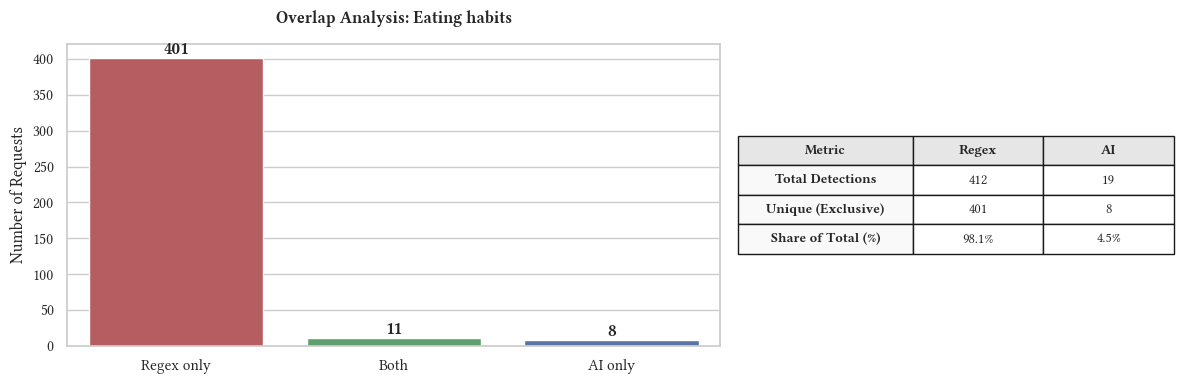


=== Deep Dive Analyse: Eating habits ===
Modus: Regex-Only Detections (Regex=True, AI=False)
Anzahl Treffer gesamt: 401
Zeige Stichprobe von n=20 (Seed=42):


,Index,App,Host,AI Reasoning,Validation Reasoning,Body Content
0,14366,com.wsl.noom,157.240.0.35,Eating habits like 'vegetarian' or 'diet' not mentioned.,None,"------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""id""\r\n\r\n830806628259122\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""ev""\r\n\r\nSubscribedButtonClick\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""dl""\r\n\r\nhttps://www.noom.com/payment/survey/happyWeightLifestyleGoal?allow_purchase=True&fcc=GB&lc=en&route=app-14-day-web-main&sp=noomapp&trial_duration_days=14&utm_source=playstore\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""rl""\r\n\r\nhttps://www.noom.com/payment/survey/course-enhancements/mental-wellness?allow_purchase=True&fcc=GB&lc=en&route=app-14-day-web-main&sp=noomapp&trial_duration_days=14&utm_source=playstore\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""if""\r\n\r\nfalse\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""ts""\r\n\r\n1709565129677\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""cd[buttonFeatures]""\r\n\r\n{""classList"":""css-czk0un e1kn1nkt4"",""destination"":"""",""id"":"""",""imageUrl"":"""",""innerText"":""Next"",""numChildButtons"":0,""tag"":""button"",""type"":""button"",""name"":"""",""value"":""""}\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""cd[buttonText]""\r\n\r\nNext\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""cd[formFeatures]""\r\n\r\n[]\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""cd[pageFeatures]""\r\n\r\n{""title"":""Noom: Stop dieting. Get lifelong results.""}\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""sw""\r\n\r\n412\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""sh""\r\n\r\n915\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""v""\r\n\r\n2.9.148\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""r""\r\n\r\nstable\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""ec""\r\n\r\n11\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""o""\r\n\r\n4126\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""fbp""\r\n\r\nfb.1.1709564779888.671401989\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""ler""\r\n\r\nempty\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""it""\r\n\r\n1709565120733\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""coo""\r\n\r\nfalse\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""es""\r\n\r\nautomatic\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""tm""\r\n\r\n3\r\n------WebKitFormBoundary03JDGD75jwcQHufW\r\nContent-Disposition: form-data; name=""rqm""\r\n\r\nSB\r\n------WebKitFormBoundary03JDGD75jwcQHufW--\r\n"
1,14362,com.wsl.noom,13.107.42.14,No dietary preferences or eating habit info found.,None,"{""pids"":[35076],""scriptVersion"":134,""time"":1709565129158,""domain"":""noom.com"",""url"":""https://noom.com/payment/survey/happyWeightLifestyleGoal?allow_purchase=True&fcc=GB&lc=en&route=app-14-day-web-main&sp=noomapp&trial_duration_days=14&utm_source=playstore"",""pageTitle"":""Noom: Stop dieting. Get lifelong results."",""websiteSignalRequestId"":""61ff239e-2e9d-fa81-a7c5-c7c92553dadc"",""isTranslated"":false,""liFatId"":"""",""liGiant"":"""",""misc"":{""psbState"":-1},""isLinkedInApp"":false,""hem"":null,""signalType"":""CLICK"",""href"":"""",""domAttributes"":{""elementSemanticType"

In [15]:
# --- Eating habits Evaluation ---
category = 'Eating habits'
regex_col = f"detected_{category}"
ai_col = f"ai_detected_{category}"
reasoning_col = f"ai_reasoning_{category}"
val_reasoning_col = f"ai_validation_reasoning_{category}"
content_col = 'request_content'

# 1. Quantitative: Overlap Plot & Table
print(f"Generiere Overlap-Plot für {category}...")
thesis_plot.plot_overlap_comparison(traffic_final, category, filename='regex_more_eating_habits')
plt.show()

# 2: Qualitative: 


thesis_plot.analyze_category(
    traffic_final, 
    category, 
    mode='regex_only', 
    sample_size=20, 
    random_seed=42,
    show_full_body=True # turn to true if the pii is not found in the front of the body
)

Notes Regex:

Notes AI Only:


   

0,4,5,6                                                Y   Likely quiz for eatiung habits, all noom.       
1 encoded string for fingerprinting, but no eating habit. but very impressive find  

"{"v2":1,"id":"6abe7f8a4d949ea78efec8895f2d77f3","t":104.3,"tag":"4.5.43","src":"js","a":{"a":{"v":"true","t":1.6},"b":{"v":"false","t":0},"c":{"v":"en-GB,en-US","t":0.1},"d":{"v":"Linux aarch64","t":0.1},"e":{"v":"","t":0.1},"f":{"v":"412w_915h_24d_2.625r","t":0},"g":{"v":"1","t":0},"h":{"v":"true","t":0},"i":{"v":"sessionStorage-enabled, localStorage-enabled","t":4},"j":{"v":"0000000100000000000110101000000000000000001000010110110","t":93,"at":2.3},"k":{"v":"","t":0},"l":{"v":"Mozilla/5.0 (Linux; Android 13; Pixel 6a Build/TP1A.220624.021.A1; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/121.0.6167.180 Mobile Safari/537.36","t":0},"m":{"v":"","t":0},"n":{"v":"false","t":91.5,"at":0.3},"o":{"v":"35b8b8e7b68b73115e5a418f6203ecd5","t":86.1}},"b":{"a":"https://X_vWOpYQw2yimPza2ldilssZ1VglAh6V3hxkTTckm14.9Zk-Xac_VffBxzmf-bH_xHGs52VPmQMvOzN_WFrPuws.g2u9-hqZvGIqYJcPlPfwJAf-v3RgyK_x1NppzAlA12M/ZjtFXzJM5VrfM489rsfH8jumvPte6GnEktF18dpUu2s/fzgx_RpFW5hL8j3FiNSWi650T5bZsztN7h-HPKAbB8o/uzrCYrWgx1ukIBBIEJu9mztGV8oMKcTDHRCdGnKs5Xo?B8NjiDP8nCQgl5ZoAjHq4VAqjXyBcphM2xFtahU_pgc=xPSOk43_YoUFS20tnvi_kmju9kK6amEnCNgO2-OJ8tc&Vq5j2LZZnKYQH-sif8PMNesJB9mDgEnnKrt4pdwsrAE=JIpcIv_MJc-ujEJ0rebMEByJbyHpPT0uO8q9XTO8rU8&iFlAt2ZeP-qxOdg6soWPKsZgEJwXmBzPfxTUKUbVR14=WW-exqGlEJ9B1e4rgBp9mztoX4WV88u90uD76rdn3mc&QnRamm9sw4q4vedgmnpZtPPBBooEJAeAjqaqe4g-68c=sV53tbxF_oS_gHMj9bYg3R8zGpbnRIlBetzcDUGUk24&oTpw9BC6FZ1WL98wBk-lpYS1kVFwHJF-GMo1NvDE2zg=ENdigm7M_6PCxJcdYo0V70dtMrixazo8eqPft6aQAz8&Bl0a58=yFHEcT&5a4Mgf=-Y5OEr","b":"https://X_vWOpYQw2yimPza2ldilssZ1VglAh6V3hxkTTckm14.9Zk-Xac_VffBxzmf-bH_xHGs52VPmQMvOzN_WFrPuws.g2u9-hqZvGIqYJcPlPfwJAf-v3RgyK_x1NppzAlA12M/QGrLGeblgjSIuWahECTAYFFi0ZVsgxNItcMoDmVyyb8/WW-exqGlEJ9B1e4rgBp9mztoX4WV88u90uD76rdn3mc/3DGE8uIo1_0LSao8k5PHEjmOGNGX2BsRQJKYSkE7wTc/?B8NjiDP8nCQgl5ZoAjHq4VAqjXyBcphM2xFtahU_pgc=xPSOk43_YoUFS20tnvi_kmju9kK6amEnCNgO2-OJ8tc&mQVklInxL3SaceBWDstWazW4caShQo6FV_W4PrjBWd4=7vlBIQ6B2NSwsEj-59OJTIFijp-TeR32QE4bbFq7D5w&Vq5j2LZZnKYQH-sif8PMNesJB9mDgEnnKrt4pdwsrAE=JIpcIv_MJc-ujEJ0rebMEByJbyHpPT0uO8q9XTO8rU8&iFlAt2ZeP-qxOdg6soWPKsZgEJwXmBzPfxTUKUbVR14=WW-exqGlEJ9B1e4rgBp9mztoX4WV88u90uD76rdn3mc&QnRamm9sw4q4vedgmnpZtPPBBooEJAeAjqaqe4g-68c=sV53tbxF_oS_gHMj9bYg3R8zGpbnRIlBetzcDUGUk24&oTpw9B=ENdigm&Bl0a58=yFHEcT&5a4Mgf=-Y5OEr#/HSoIyGqGoiFkVzAryDPm8OrK5XKAubYHFR5Eefxh6Rc","c":"nUM_dvfGN_aybzJuJ8Ro7TjvEwQGuVnHX_z9exn7rLA","d":"NA","e":"NA","f":false,"g":true,"h":true,"i":["location"],"j":[],"n":424,"u":"www.noom.com","v":"www.noom.com","w":"1709565249777:58d2fafe15c4fa519eebfe106af112bbdbd6b63a4265b3b25bd71b4f9a9b12bc"},"h":"cac10a5da7bc213ba0f2"}"

2 True positive. eating habit
3 22266    FP, but pii in gzip., but no eating habits. this is final string." [{"_track_id":883265898,"time":1709406487378,"type":"track","distinct_id":"462c1d38a43b1872","anonymous_id":"462c1d38a43b1872","lib":{"$lib_method":"code","$lib":"Android","$lib_version":"5.4.4","$app_version":"8.43.00","$lib_detail":"com.sensorsdata.analytics.android.sdk.AbstractSensorsDataAPI##trackEventInternal##SourceFile##93"},"event":"pageview_general_h2o","properties":{"$os_version":"13","$model":"Pixel 6a","$os":"Android","$screen_width":1080,"$brand":"GOOGLE","$screen_height":2400,"$app_version":"8.43.00","$lib":"Android","$device_id":"462c1d38a43b1872","$app_name":"Daily Yoga","$lib_version":"5.4.4","$timezone_offset":-60,"$app_id":"com.dailyyoga.inc","$manufacturer":"GOOGLE","channel":"google","AppName":"DailyYoga","platform_h2o":"1","format_app_version":"8.43.00","language":"2","vip_userinfo":-1,"kol_userinfo":0,"meditation_userinfo":0,"book_userinfo":0,"is_notification_authorized":false,"pub_reminder":1,"bind_with_applegooglehealth":0,"firebase_country_dy":"0","$wifi":true,"$network_type":"WIFI","page_id":395,"pageinfo":"","notification_authorized":false,"$lib_method":"code","$is_first_day":true,"$lib_plugin_version":["android:3.4.1"]},"_flush_time":1709406487419},{"_track_id":-145841895,"time":1709406487410,"type":"track","distinct_id":"462c1d38a43b1872","anonymous_id":"462c1d38a43b1872","lib":{"$lib_method":"code","$lib":"Android","$lib_version":"5.4.4","$app_version":"8.43.00","$lib_detail":"com.sensorsdata.analytics.android.sdk.AbstractSensorsDataAPI##trackEventInternal##SourceFile##93"},"event":"exo_player_h2o","properties":{"$os_version":"13","$model":"Pixel 6a","$os":"Android","$screen_width":1080,"$brand":"GOOGLE","$screen_height":2400,"$app_version":"8.43.00","$lib":"Android","$device_id":"462c1d38a43b1872","$app_name":"Daily Yoga","$lib_version":"5.4.4","$timezone_offset":-60,"$app_id":"com.dailyyoga.inc","$manufacturer":"GOOGLE","channel":"google","AppName":"DailyYoga","platform_h2o":"1","format_app_version":"8.43.00","language":"2","vip_userinfo":-1,"kol_userinfo":0,"meditation_userinfo":0,"book_userinfo":0,"is_notification_authorized":false,"pub_reminder":1,"bind_with_applegooglehealth":0,"firebase_country_dy":"0","$wifi":true,"$network_type":"WIFI","is_support":1,"decoder_failed":0,"$lib_method":"code","$is_first_day":true},"_flush_time":1709406487419},{"_track_id":-237501125,"time":1709406487415,"type":"track","distinct_id":"462c1d38a43b1872","anonymous_id":"462c1d38a43b1872","lib":{"$lib_method":"autoTrack","$lib":"Android","$lib_version":"5.4.4","$app_version":"8.43.00","$lib_detail":"com.dailyyoga.inc.LoadingActivity######"},"event":"$AppStart","properties":{"$os_version":"13","$model":"Pixel 6a","$os":"Android","$screen_width":1080,"$brand":"GOOGLE","$screen_height":2400,"$app_version":"8.43.00","$lib":"Android","$device_id":"462c1d38a43b1872","$app_name":"Daily Yoga","$lib_version":"5.4.4","$timezone_offset":-60,"$app_id":"com.dailyyoga.inc","$manufacturer":"GOOGLE","channel":"google","AppName":"DailyYoga","platform_h2o":"1","format_app_version":"8.43.00","language":"2","vip_userinfo":-1,"kol_userinfo":0,"meditation_userinfo":0,"book_userinfo":0,"is_notification_authorized":false,"pub_reminder":1,"bind_with_applegooglehealth":0,"firebase_country_dy":"0","$wifi":true,"$network_type":"WIFI","$resume_from_background":false,"$is_first_time":true,"$screen_name":"com.dailyyoga.inc.LoadingActivity","$title":"Daily Yoga","$lib_method":"autoTrack","$is_first_day":true},"_flush_time":1709406487419}]"  


7 Fp. could not find out what was decoded here. 

Maybe include that one. 

In [32]:
# --- Detail-Check für einen spezifischen Request Index ---

target_index = 14818

if target_index in traffic_final.index:
    print(f"=== Analyse für Request Index {target_index} ===")
    row = traffic_final.loc[target_index]
    
    print(f"App: {row['package_name']}")
    print(f"Host: {row['remote_host']}")
    print("-" * 40)
    
    # Wir prüfen alle Kategorien
    found_something = False
    for pattern in r_combined_all:
        name = pattern['name']
        regex_res = row.get(f'detected_{name}', False)
        ai_res = row.get(f'ai_detected_{name}', False)
        ai_reason = row.get(f'ai_reasoning_{name}', '')
        
        # Wir zeigen nur an, wenn IRGENDWER was gefunden hat
        if regex_res or ai_res:
            found_something = True
            print(f"Kategorie: {name}")
            print(f"  Regex: {regex_res}")
            print(f"  AI:    {ai_res}")
            if ai_res:
                print(f"  Reasoning: {ai_reason}")
            print("-" * 20)
            
    if not found_something:
        print("Weder Regex noch KI haben in diesem Request irgendwelche PII gefunden.")
        
    # Optional: Content nochmal anzeigen (gekürzt)
    content = str(row['request_content'])
    print("\nContent Snippet:")
    print(content[:200] + "..." if len(content) > 200 else content)

else:
    print(f"Index {target_index} nicht im DataFrame gefunden.")

=== Analyse für Request Index 14818 ===
App: com.wsl.noom
Host: m.stripe.com
----------------------------------------
Kategorie: Device model
  Regex: False
  AI:    True
  Reasoning: Pixel 6A and bluejay mentioned in user agent string.
--------------------
Kategorie: Resolution
  Regex: False
  AI:    True
  Reasoning: 1080 resolution indicated in user agent or related fields.
--------------------
Kategorie: Carrier name
  Regex: False
  AI:    True
  Reasoning: Carrier 'nettokom' explicitly present in data.
--------------------
Kategorie: OS build
  Regex: False
  AI:    True
  Reasoning: OS build 'TP1A.220624.021.A1' found in user agent string.
--------------------
Kategorie: API level
  Regex: False
  AI:    True
  Reasoning: API level 33 referenced in device info.
--------------------
Kategorie: City
  Regex: False
  AI:    True
  Reasoning: City 'Berlin' explicitly mentioned in location data.
--------------------
Kategorie: Latitude
  Regex: False
  AI:    True
  Reasoning: Latit